<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Synchro-Project" data-toc-modified-id="Synchro-Project-1">Synchro Project</a></span><ul class="toc-item"><li><span><a href="#TOC" data-toc-modified-id="TOC-1.1">TOC</a></span></li><li><span><a href="#1.-setup" data-toc-modified-id="1.-setup-1.2">1. setup</a></span></li><li><span><a href="#2.-get-data" data-toc-modified-id="2.-get-data-1.3">2. get data</a></span><ul class="toc-item"><li><span><a href="#2.A.-nan-remover" data-toc-modified-id="2.A.-nan-remover-1.3.1">2.A. nan remover</a></span></li><li><span><a href="#2.B.-add-features" data-toc-modified-id="2.B.-add-features-1.3.2">2.B. add features</a></span></li><li><span><a href="#2.C.-pandas-report" data-toc-modified-id="2.C.-pandas-report-1.3.3">2.C. pandas report</a></span></li><li><span><a href="#2.D.-save-data" data-toc-modified-id="2.D.-save-data-1.3.4">2.D. save data</a></span></li><li><span><a href="#2.E.-split-data" data-toc-modified-id="2.E.-split-data-1.3.5">2.E. split data</a></span></li></ul></li><li><span><a href="#3.-Pipeline" data-toc-modified-id="3.-Pipeline-1.4">3. Pipeline</a></span></li><li><span><a href="#4.-optimization" data-toc-modified-id="4.-optimization-1.5">4. optimization</a></span></li><li><span><a href="#5.-feature-importance" data-toc-modified-id="5.-feature-importance-1.6">5. feature importance</a></span></li><li><span><a href="#6.-diagnostic" data-toc-modified-id="6.-diagnostic-1.7">6. diagnostic</a></span></li><li><span><a href="#7.-evaluation" data-toc-modified-id="7.-evaluation-1.8">7. evaluation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Hotelling" data-toc-modified-id="Hotelling-1.8.0.1">Hotelling</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Synchro Project
- [github link](https://github.com/romainmartinez/envergo)

## TOC
1. setup
2. get data
    1. nan remover
    2. add features
    3. pandas report
    4. save data
    5. split data
3. pipeline
4. optimization
5. features importance
6. diagnostic
7. evaluation

## 1. setup

In [1]:
# Common imports
import scipy.io as sio
import pandas as pd
import numpy as np
import os

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 2. get data

In [2]:
# load from mat
DATA_PATH = './data/'
X_import = sio.loadmat(os.path.join(DATA_PATH, 'X.mat'))['TableauForces']
y_import = sio.loadmat(os.path.join(DATA_PATH, 'y.mat'))['TestData']

X_description = np.array(['AddL', 'AddR', 'AbdL', 'AbdR', 'ErL', 'ErR', 'IrL', 'IrR', 'ExtL', 'ExtR', 'FlexL', 'FlexR'])
y_description = np.array(['Dyn', 'BodyBoost', 'MeanEggBeater', 'MaxEggBeater'])

### 2.A. nan remover

In [3]:
nan_id = np.argwhere(np.isnan(X_import))
n_nans = np.sum(np.isnan(X_import).sum(axis=1))
for i in nan_id:
    print(f'\tparticipant n: {i[0]}')
    print(f'\ttest: {X_description[i[1]]}')
    # if left take right, left otherwise
    if X_description[i[1]][-1] == 'L':
        replacer = i[1] + 1
    elif X_description[i[1]][-1] == 'R':
        replacer = i[1] - 1
    print(f'\t\t"{X_import[i[0], i[1]]}" replace by "{X_import[i[0], replacer]}"')
    X_import[i[0], i[1]] = X_import[i[0], replacer]
    print('\t', '-' * 5)

	participant n: 1
	test: IrL
		"nan" replace by "118.95"
	 -----
	participant n: 51
	test: IrL
		"nan" replace by "92.25"
	 -----


### 2.B. add features

In [4]:
# load height + weight
anthropo = sio.loadmat(os.path.join(DATA_PATH, 'heightweight.mat'))['HeightWeight']
# replace nan
from sklearn.preprocessing import Imputer
anthropo = Imputer(strategy='median').fit_transform(anthropo)
# add IMC
anthropo = np.c_[anthropo, anthropo[:, 1] / (anthropo[:, 0])**2]

In [5]:
# compute imbalance
imbalance = None
for i in range(0, X_import.shape[1], 2):
    if imbalance is None:
        imbalance = np.abs((X_import[:, i] - X_import[:, i + 1]) / X_import[:, i]) * 100
    else:
        imbalance = np.c_[imbalance, np.abs((X_import[:, i] - X_import[:, i + 1]) / X_import[:, i]) * 100]
imbalance = np.mean(imbalance, axis=1)

In [6]:
X_mat = np.c_[X_import, anthropo, imbalance]
X_description = np.append(X_description, ['height', 'weight', 'IMC', 'imbalance'])

In [7]:
df = pd.DataFrame(
    data=np.c_[X_mat, y_import],
    columns=np.append(X_description, y_description)
)

In [8]:
X_cols = {
    'test': np.arange(12),
    'height': np.array([12]),
    'weight': np.array([13]),
    'IMC': np.array([14]),
    'imbalance': np.array([15])
}

### 2.C. pandas report

In [9]:
REPORT_FILENAME = './pandas_report.html'
if not os.path.isfile(REPORT_FILENAME):
    import pandas_profiling
    report = pandas_profiling.ProfileReport(df)
    report.to_file('./pandas_report.html')

### 2.D. save data

In [10]:
FILENAME = './data/dataframe.hdf5'
df.to_hdf(FILENAME, 'SYNCHRO', format='table')

### 2.E. split data

In [11]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mat, y_import, test_size=0.2, random_state=RANDOM_SEED)

## 3. Pipeline

In [12]:
# custom class
from sklearn.base import BaseEstimator, TransformerMixin

class Normalize(BaseEstimator, TransformerMixin):
    """Normalize a given array with weight, height or IMC"""
    def __init__(self, X_cols=X_cols, strategy='IMC'):
        self.strategy = strategy
        self.X_cols = X_cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if self.strategy == 'height':
            normalizer = X_copy[:, X_cols['height']].reshape(-1, 1)
        elif self.strategy == 'weight':
            normalizer = X_copy[:, X_cols['weight']].reshape(-1, 1)
        elif self.strategy == 'IMC':
            normalizer = X_copy[:, X_cols['IMC']].reshape(-1, 1)
        else:
            raise ValueError(f'please choose one of the following: height, weight, IMC. You have chosen {self.strategy}')
        X_copy[:, X_cols['test']] = X_copy[:, X_cols['test']] / normalizer
        return X_copy
    
class TestSide(BaseEstimator, TransformerMixin):
    """Return the mean between left & right or both"""
    def __init__(self, X_cols=X_cols, strategy='mean'):
        self.strategy = strategy
        self.X_cols = X_cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.strategy is 'mean' or 'Fscore':
            output = X.copy()
            for i in range(X_cols['test'][-1] + 1):
                if i % 2 == 0:
                    if self.strategy is 'mean':
                        output[:, i] = np.mean([X[:, i], X[:, i + 1]], axis=0)
                    else:
                        output[:, i] = 2 * (X[:, i] * X[:, i + 1]) / (X[:, i] + X[:, i + 1])
                else:
                    output[:, i] = np.nan
        else:
            raise ValueError('please choose one of the following: mean, Fscore')
        return output
    
class FeaturesAdder(BaseEstimator, TransformerMixin):
    """Add features based on the list `new_features`
    Possible `new_features` are: IMC, imbalance
    """
    def __init__(self, X_cols=X_cols, new_features='None'):
        self.new_features = new_features
        self.X_cols = X_cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for key, cols in X_cols.items():
            if not key in self.new_features:
                X_copy[:, cols] = np.nan
        return X_copy[:, ~np.all(np.isnan(X_copy), axis=0)]  # remove nan columns

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

preprocessing = make_pipeline(
    Normalize(strategy='IMC'),
    TestSide(strategy='Fscore'),
    FeaturesAdder(new_features=['test', 'height', 'weight', 'IMC', 'imbalance']),
    PolynomialFeatures(degree=1)
)

In [14]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

full_pipeline = make_pipeline(
    preprocessing,
    MultiOutputRegressor(XGBRegressor())
)

## 4. optimization

In [15]:
stuff = ['test', 'height', 'weight', 'IMC', 'imbalance']

In [16]:
import itertools

all_possible_features = ['test', 'height', 'weight', 'IMC', 'imbalance']
all_features_combinations = []
for L in range(1, len(all_possible_features)+1):
    for subset in itertools.combinations(all_possible_features, L):
        all_features_combinations.append(list(subset))
all_features_combinations

[['test'],
 ['height'],
 ['weight'],
 ['IMC'],
 ['imbalance'],
 ['test', 'height'],
 ['test', 'weight'],
 ['test', 'IMC'],
 ['test', 'imbalance'],
 ['height', 'weight'],
 ['height', 'IMC'],
 ['height', 'imbalance'],
 ['weight', 'IMC'],
 ['weight', 'imbalance'],
 ['IMC', 'imbalance'],
 ['test', 'height', 'weight'],
 ['test', 'height', 'IMC'],
 ['test', 'height', 'imbalance'],
 ['test', 'weight', 'IMC'],
 ['test', 'weight', 'imbalance'],
 ['test', 'IMC', 'imbalance'],
 ['height', 'weight', 'IMC'],
 ['height', 'weight', 'imbalance'],
 ['height', 'IMC', 'imbalance'],
 ['weight', 'IMC', 'imbalance'],
 ['test', 'height', 'weight', 'IMC'],
 ['test', 'height', 'weight', 'imbalance'],
 ['test', 'height', 'IMC', 'imbalance'],
 ['test', 'weight', 'IMC', 'imbalance'],
 ['height', 'weight', 'IMC', 'imbalance'],
 ['test', 'height', 'weight', 'IMC', 'imbalance']]

In [17]:
xgb_param = {
    'multioutputregressor__estimator__max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'multioutputregressor__estimator__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'multioutputregressor__estimator__n_estimators': [10, 25, 50, 150, 200],
    'multioutputregressor__estimator__gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.10],
    'multioutputregressor__estimator__min_child_weight': [1, 3, 5, 7],
    'multioutputregressor__estimator__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'multioutputregressor__estimator__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'multioutputregressor__estimator__reg_lambda': [0.01, 0.1, 1.0],
    'multioutputregressor__estimator__reg_alpha': [0, 0.1, 0.5, 1.0]
}

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

optimize = True
MODEL_FILENAME = 'xgboost_model.pkl'

if optimize:
    param_grid = [{
        'pipeline__normalize': [None, Normalize(strategy='height'), Normalize('weight'), Normalize('IMC')],
        'pipeline__testside': [None, TestSide(strategy='mean'), TestSide(strategy='Fscore')],
        'pipeline__featuresadder__new_features': all_features_combinations,
        'pipeline__polynomialfeatures': [None],
        }]

    grid_search_prep = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error',
                                    verbose=1)

    grid_search_prep.fit(X_train, y_train)
    model = grid_search_prep
    joblib.dump(model, MODEL_FILENAME)
else:
    model = joblib.load(MODEL_FILENAME) 

Fitting 5 folds for each of 372 candidates, totalling 1860 fits


[Parallel(n_jobs=1)]: Done 1860 out of 1860 | elapsed:   58.4s finished


In [22]:
model.best_score_

-0.9747966161620677

In [20]:
model.best_params_

{'pipeline__featuresadder__new_features': ['test', 'IMC'],
 'pipeline__normalize': Normalize(X_cols={'test': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'height': array([12]), 'weight': array([13]), 'IMC': array([14]), 'imbalance': array([15])},
      strategy='height'),
 'pipeline__polynomialfeatures': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
 'pipeline__testside': TestSide(X_cols={'test': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'height': array([12]), 'weight': array([13]), 'IMC': array([14]), 'imbalance': array([15])},
      strategy='Fscore')}

In [21]:
from sklearn.base import clone
xi = clone(full_pipeline)
xi.set_params(**model.best_params_)
xi.fit(X_train, y_train.ravel())

Normalize_transform: shape = (42, 16)
FeatureAdder_transform: shape = (42, 14)


ValueError: Found input variables with inconsistent numbers of samples: [42, 168]

---

In [18]:
grid_search_prep.best_params_

{'pipeline__featuresadder__new_features': ['test', 'weight'],
 'pipeline__normalize__strategy': 'weight',
 'pipeline__testside__strategy': 'mean'}

In [19]:
grid_search_prep.best_score_

-0.97362502907769455

without optimization: -0.97362502907769455

## 5. feature importance

In [23]:
regressors = model.best_estimator_.named_steps["multioutputregressor"]
for ilabel in range(y_test.shape[1]):
    fscore = regressors.estimators_[ilabel].booster().get_fscore()
    if ilabel is 0:
        importance = pd.DataFrame(data={y_description[ilabel]: list(fscore.values())},
                                  index=list(fscore.keys()))
    else:
        temp = pd.DataFrame(data={y_description[ilabel]: list(fscore.values())},
                                  index=list(fscore.keys()))
        importance = importance.join(temp)
importance.sort_index(inplace=True)

TypeError: 'str' object is not callable

In [21]:
relative_importance = (importance.div(importance.sum(axis=1), axis=0)) * 100
relative_importance['features'] = relative_importance.index
# to tidy
relative_importance = pd.melt(relative_importance, id_vars='features',
                              var_name='label', value_name='importance')

In [22]:
selected_features = ['Add', 'Abd', 'Er', 'Ir', 'Ext', 'Flex', 'weight']

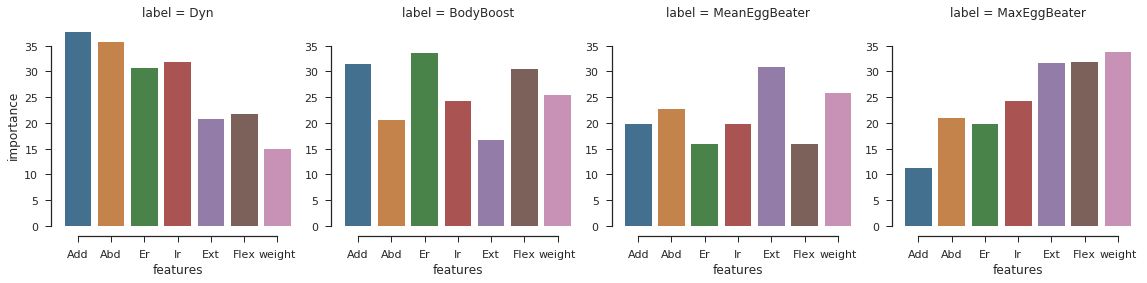

In [23]:
g = sns.factorplot(data=relative_importance, x='features', y='importance', col='label', kind='bar',
                   saturation=.5)
g.set_xticklabels(selected_features)
sns.despine(offset=10, trim=True)
plt.show()

## 6. diagnostic

In [24]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, scoring, cv=None, title=None, ylim=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return train_scores


In [25]:
a = full_pipeline
a.set_params(**grid_search_prep.best_params_)


Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('normalize', Normalize(X_cols={'test': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'height': array([12]), 'weight': array([13]), 'IMC': array([14]), 'imbalance': array([15])},
     strategy='weight')), ('testside', TestSide(X_cols={..., reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
           n_jobs=1))])

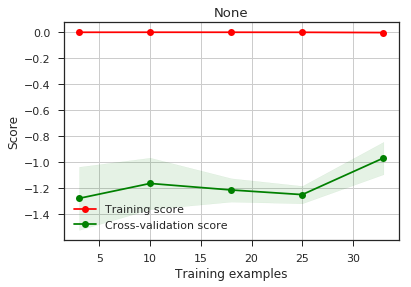

In [26]:
from sklearn.model_selection import learning_curve

title = 'coucou'
scoring = 'neg_mean_squared_error'
t = plot_learning_curve(a, X_train, y_train, scoring, cv=5)
plt.show()

In [27]:
train_sizes, train_scores, test_scores = learning_curve(grid_search_prep.best_estimator_, X_train, y_train, cv=5,
                                                        scoring='neg_mean_squared_error')

The complex pipeline is certainly not suffering from high bias, as that would imply a higher error on the training set. From the gap between training and test error it rather seems like the model may exhibit too much variance, i.e. overfitting on the training folds. This makes sense both because our model is rather complex, and also because the size of the whole training data is relatively small (less than 8000 documents, compare that to the number of features produced by the tf-df, which can run into several tens of thousands without dimensionality reduction). Collection of more data would thus be one way to try and improve performance here (and it might also be useful to investigate different forms of regularization to avoid overfitting. Interestingly though, grid-search of the logistic regression led to best results without regularization). On the other hand, test error does not seem to be decreasing much with increasing size of the training set, indicating perhaps some inherent unpredictability in the data (some comments in the forum e.g. indicate that the class labels seem to have been assigned somewhat inconsistently).

## 7. evaluation

In [28]:
y_pred = grid_search_prep.best_estimator_.predict(X_test)

In [29]:
from sklearn.metrics import mean_squared_error
import spm1d

def mape(y_test, y_pred):
    val = (np.abs((y_test - y_pred) / y_test)) * 100
    return np.mean(val), np.std(val)

def mse(y_test, y_pred):
    val = ((y_test - y_pred) ** 2)
    return np.mean(val), np.std(val)

def rmse(y_test, y_pred):
    val = np.sqrt(((y_test - y_pred) ** 2))
    return np.mean(val), np.std(val)

def t_test(y_test, y_pred, alpha=0.05, iterations=10000):
    spm = spm1d.stats.nonparam.ttest2(y_test, y_pred)
    spmi = spm.inference(alpha, two_tailed=True,
                           iterations=iterations, force_iterations=True)
    if spmi.h0reject:
        output = f'null hypothesis rejected, T2={spmi.z:.3f}, p={spmi.p:.5f}'
    else:
        output = f'null hypothesis not rejected (p={spmi.p:.5f})'
    print(f'\tt-test = {output}')

def evaluate(y_test, y_pred, y_description):
    for i in range(y_pred.shape[1]):
        print(y_description[i])
        mse_mu, mse_std = mse(y_test[:, i], y_pred[:, i])
        rmse_mu, rmse_std = rmse(y_test[:, i], y_pred[:, i])
        mape_mu, mape_std = mape(y_test[:, i], y_pred[:, i])
        
        print(f'\tmse = {mse_mu:.3f} ({mse_std:.3f})')
        print(f'\trmse = {rmse_mu:.3f} ({rmse_std:.3f})')
        print(f'\tmape = {mape_mu:.3f}% ({mape_std:.3f})')
        
        t_test(y_test[:, i], y_pred[:, i])
    
        print('-' * 10)

In [30]:
evaluate(y_test, y_pred, y_description)

Dyn
	mse = 4.476 (6.250)
	rmse = 1.646 (1.329)
	mape = 15.300% (10.019)
	t-test = null hypothesis not rejected (p=0.02880)
----------
BodyBoost
	mse = 0.540 (0.617)
	rmse = 0.565 (0.470)
	mape = 6.190% (5.005)
	t-test = null hypothesis not rejected (p=0.03800)
----------
MeanEggBeater
	mse = 0.446 (0.394)
	rmse = 0.582 (0.327)
	mape = 7.660% (4.348)
	t-test = null hypothesis not rejected (p=0.83140)
----------
MaxEggBeater
	mse = 1.061 (0.599)
	rmse = 0.937 (0.428)
	mape = 11.496% (5.257)
	t-test = null hypothesis not rejected (p=0.85420)
----------


#### Hotelling

In [32]:
t_spm = spm1d.stats.nonparam.hotellings2(y_test, y_pred)
t_spmi = t_spm.inference(alpha=0.05, iterations=10000)

print(t_spmi)

SnPM{T2} inference (0D)
   SPM.z              :  13.780
   SnPM.nPermUnique   :  705432 permutations possible
Inference:
   SnPM.nPermActual   :  10000 actual permutations
   SPM.alpha          :  0.050
   SPM.zstar          :  13.63274
   SPM.h0reject       :  True
   SPM.p              :  0.048

